In [36]:
import os
import numpy as np
import scipy
import librosa
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from python_speech_features import mfcc
%matplotlib inline

In [37]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

In [38]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [39]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def met_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

In [40]:
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = met_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs


In [41]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [42]:
def pad_audio(data, fs, T=3):
    # Calculate target number of samples
    N_tar = int(fs * T)
    # Calculate number of zero samples to append
    shape = data.shape
    # Create the target shape    
    N_pad = N_tar - shape[0]
    #print("Padding with %s seconds of silence" % str(N_pad/fs) )
    shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(shape),
                              data))
        else:
            return np.hstack((np.zeros(shape),
                              data))
    else:
        return data

In [43]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [44]:
def create_cepstral_coefficients(file):
    sample_rate, audio = wavfile.read(file)
    audio = pad_audio(audio, sample_rate)
    
    hop_size = 10#ms
    FFT_size = 1024

    audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)

    window = get_window("hann", FFT_size, fftbins=True)

    audio_win = audio_framed * window

    ind = 6

    audio_winT = np.transpose(audio_win)

    audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

    for n in range(audio_fft.shape[1]):
        audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

    audio_fft = np.transpose(audio_fft)

    audio_power = np.square(np.abs(audio_fft))

    freq_min = 0
    freq_high = sample_rate / 2
    mel_filter_num = 10
    
    filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)

    
    filters = get_filters(filter_points, FFT_size)

    # taken from the librosa library
    enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
    filters *= enorm[:, np.newaxis]

    audio_filtered = np.dot(filters, np.transpose(audio_power))
    audio_log = 10.0 * np.log10(audio_filtered)
    audio_log.shape

    dct_filter_num = 40

    dct_filters = dct(dct_filter_num, mel_filter_num)

    cepstral_coefficents = np.dot(dct_filters, audio_log)

    
    return cepstral_coefficents



In [45]:
import boto3

In [46]:
import os
# assign directory

# import glob

# output = []
# labels = []

# for subdir, dirs, files in os.walk(rootdir):
#     for file in files:

#         if 'chunk' in file:
#             labels.append(os.path.join(subdir, file).split('-')[3])
#             data = create_cepstral_coefficients(os.path.join(subdir, file))
#             where_are_NaNs = np.isnan(data)
#             data[where_are_NaNs] = 0
#             data[data == -np.inf] = 0
#             data[data == np.inf] = 0
#             output.append(data.flatten())
            


In [47]:
# cepstrals = np.array(output)

In [48]:
# from sklearn import svm

# clf = svm.SVC(gamma=0.001, C=100)
# #print(labels.shape)

# labels = np.array(labels).ravel()
# print(labels)
# #labels = np.concatenate(labels, axis=1)
# cepstrals.shape
# #clf.fit(cepstrals, labels)

In [49]:
# 


In [50]:
# X_train, X_test, y_train, y_test = train_test_split(cepstrals, labels, test_size=0.3,random_state=109) # 70% training and 30% test

In [51]:
# labels.ravel()

In [52]:
# clf.fit(X_train, y_train)

In [53]:
# y_pred = clf.predict(X_test)

In [54]:
# 
# print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [55]:
def load_audio():
    rootdir = 'dataset/'
    labels = []
    letters = []
    for subdir, dirs, files in os.walk(rootdir):

        for file in files:
            
            if 'chunk' in file:
                audio, sample_rate = librosa.load(os.path.join(subdir, file))

                data = pad_audio(audio, sample_rate)
                label = os.path.join(subdir, file).split('-')[3]
                letters.append((data, sample_rate, label))
              

    
    return letters

# How to use load_audio() function
characters = load_audio()

In [64]:
characters


[(array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'A'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050, 'B'),
 (array([0., 0., 0., ..., 0., 0., 0.]), 22050,

In [65]:
def extract_features(audio_data):

	# Remember that the audio data consists of raw audio wave followed by sample rate
	# so we need to only take the raw audio wave.
    output, label_output = [],[]

    for i in audio_data:

        audio_waves = i[0]
        samplerate = i[1]
        letter = i[2]
        n_fft = int(samplerate * 0.02)
        data = mfcc(audio_waves, samplerate=samplerate, nfft=2048,winfunc=np.hamming)
        label_output.append(letter)
        features = np.array(data)
        output.append(features.flatten())

    label_output = np.array(label_output)
    return output, label_output

# Define a function to load the raw audio files

character_features, labels = extract_features(characters)

In [ ]:
c

In [66]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X = character_features
Y = labels

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=30, stratify=Y)


In [67]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf')

In [68]:
clf.fit(X_train, y_train)

SVC()

In [69]:
y_pred = clf.predict(X_test)

In [70]:
print("Accuracy:",metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.6153846153846154


/home/brucebeck/.local/share/virtualenvs/Masters-Vwceh9VJ/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


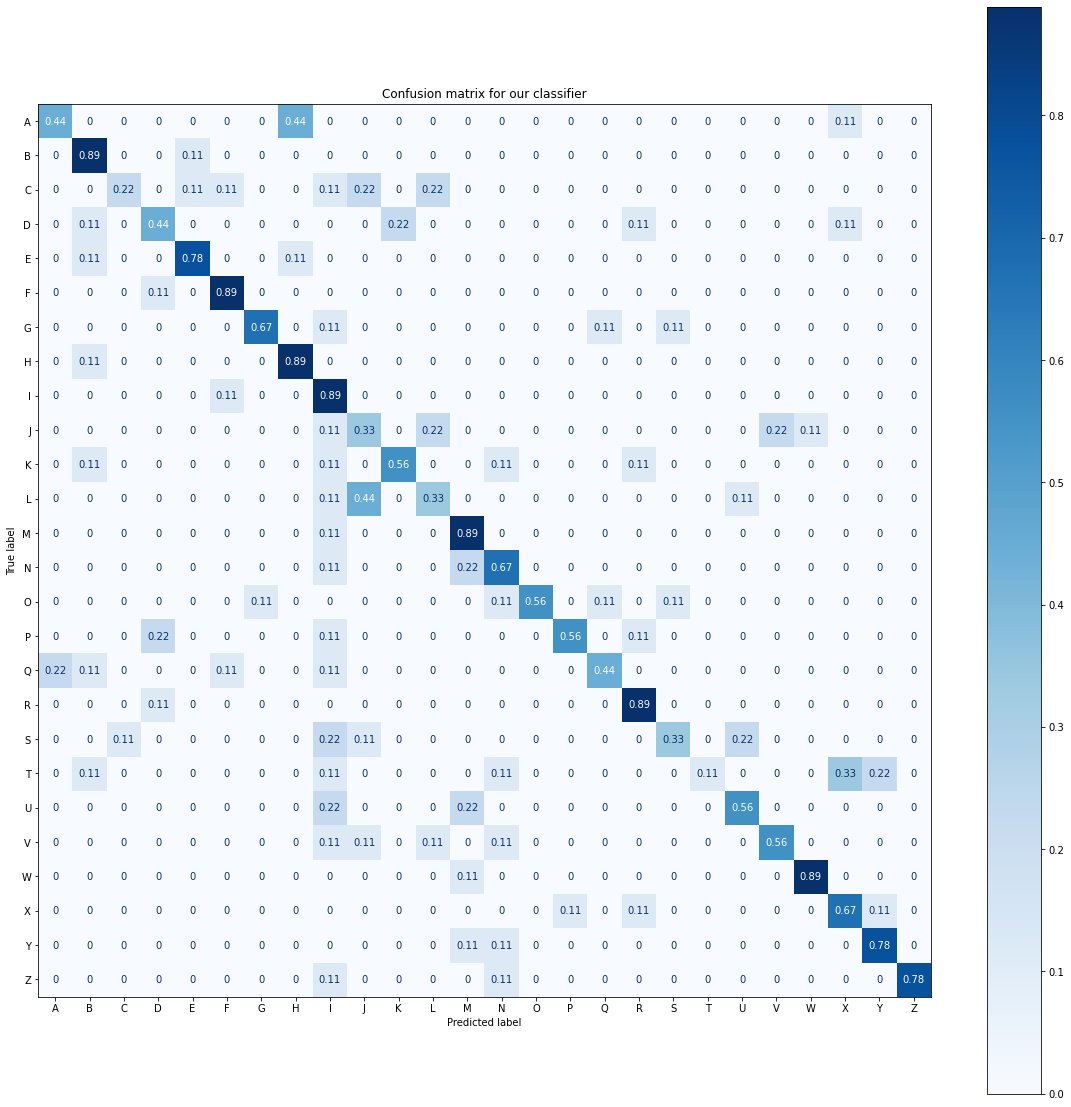

In [71]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(20, 20))
matrix = plot_confusion_matrix(clf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true',ax=ax)
plt.title('Confusion matrix for our classifier')
plt.show(matrix)
plt.show()


In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           A       0.80      0.44      0.57         9
           B       0.57      0.89      0.70         9
           C       0.50      0.22      0.31         9
           D       0.67      0.44      0.53         9
           E       0.78      0.78      0.78         9
           F       0.75      1.00      0.86         9
           G       0.71      0.56      0.63         9
           H       0.62      0.89      0.73         9
           I       0.33      0.89      0.48         9
           J       0.27      0.33      0.30         9
           K       0.71      0.56      0.63         9
           L       0.38      0.33      0.35         9
           M       0.57      0.89      0.70         9
           N       0.50      0.67      0.57         9
           O       1.00      0.67      0.80         9
           P       0.86      0.67      0.75         9
           Q       0.71      0.56      0.63         9
           R       0.67    